In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/Shareddrives/OPML/20210807_Titanic/敬倫

/content/drive/Shareddrives/OPML/Seminar/20210807_Titanic_廖家緯/敬倫


In [ ]:
!ls

 lightning_logs  'titanic (1).ipynb'   titanic.ipynb


# Import Packages

In [ ]:
!pip install pytorch_lightning

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

In [ ]:
from pytorch_lightning import LightningModule, LightningDataModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger

# Setup

In [ ]:
import os
os.listdir("..")

['敬倫',
 'test.csv',
 'train.csv',
 'gender_submission.csv',
 '家緯',
 '翊誠',
 '俊廷',
 '彥嘉',
 '楷元']

In [ ]:
dataset = pd.read_csv('../train.csv')
dataset.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
print(dataset.shape)
dataset.dtypes

(891, 12)


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
# pclass
pclass = np.zeros([891, 3])

for i, c in enumerate(dataset.Pclass):
    pclass[i, c-1] = 1

In [ ]:
# sex
sex = dataset.Sex.map(lambda x: int(x == "male")).values

In [ ]:
X = np.hstack([
    pclass,
    sex.reshape(-1, 1),
    dataset.SibSp.values.reshape(-1, 1),
    dataset.Parch.values.reshape(-1, 1),
    dataset.Fare.values.reshape(-1, 1)
])
X.shape

(891, 7)

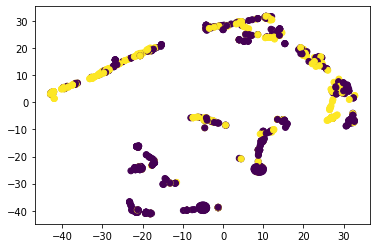

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

embed = TSNE().fit_transform(X)

plt.scatter(embed[:, 0], embed[:, 1], c=dataset.Survived)
plt.show()

## Feature Enginnering

### Title

In [ ]:
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'] = dataset['Title'].replace(
    [
      'Lady',
      'the Countess',
      'Countess',
      'Capt',
      'Col',
      'Don',
      'Dr',
      'Major',
      'Rev',
      'Sir',
      'Jonkheer',
      'Dona',
      'Ms',
      'Mme',
      'Mlle'
    ], 'Rare')
dataset['Title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: Title, dtype: int64

### Family

In [ ]:
def family(x):
    if x < 2:
        return 'Single'
    
    elif x == 2:
        return 'Couple'
    
    elif x <= 4:
        return 'InterM'
    
    else:
        return 'Large'

dataset['FamilyS'] = dataset['SibSp'] + dataset['Parch'] + 1   
dataset['FamilyS'] = dataset['FamilyS'].apply(family)
dataset['FamilyS']

0      Couple
1      Couple
2      Single
3      Couple
4      Single
        ...  
886    Single
887    Single
888    InterM
889    Single
890    Single
Name: FamilyS, Length: 891, dtype: object

### Embarked

In [ ]:
dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)
dataset['Embarked']

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

### Age

In [ ]:
dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
dataset['Age']

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    28.0
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

## Dataset

In [ ]:
dataset = dataset.drop(['PassengerId', 'Cabin', 'Name', 'SibSp', 'Parch', 'Ticket'], axis=1)
X_train = dataset.iloc[:, 1:9].values
Y_train = dataset.iloc[:, 0].values

X_train

array([[3, 'male', 22.0, ..., 'S', 'Mr', 'Couple'],
       [1, 'female', 38.0, ..., 'C', 'Mrs', 'Couple'],
       [3, 'female', 26.0, ..., 'S', 'Miss', 'Single'],
       ...,
       [3, 'female', 28.0, ..., 'S', 'Miss', 'InterM'],
       [1, 'male', 26.0, ..., 'C', 'Mr', 'Single'],
       [3, 'male', 32.0, ..., 'Q', 'Mr', 'Single']], dtype=object)

In [ ]:
labelencoder_X_1 = LabelEncoder()
X_train[:, 1] = labelencoder_X_1.fit_transform(X_train[:, 1])
X_train[:, 4] = labelencoder_X_1.fit_transform(X_train[:, 4])
X_train[:, 5] = labelencoder_X_1.fit_transform(X_train[:, 5])
X_train[:, 6] = labelencoder_X_1.fit_transform(X_train[:, 6])

X_train

array([[3, 1, 22.0, ..., 2, 2, 0],
       [1, 0, 38.0, ..., 0, 3, 0],
       [3, 0, 26.0, ..., 2, 1, 3],
       ...,
       [3, 0, 28.0, ..., 2, 1, 1],
       [1, 1, 26.0, ..., 0, 2, 3],
       [3, 1, 32.0, ..., 1, 2, 3]], dtype=object)

In [ ]:
ct = ColumnTransformer([('one_hot_encoder', OneHotEncoder(), [0, 1, 4, 5, 6])], remainder='passthrough')
X_train = np.array(ct.fit_transform(X_train), dtype=np.float32)
X_train

array([[ 0.    ,  0.    ,  1.    , ...,  0.    , 22.    ,  7.25  ],
       [ 1.    ,  0.    ,  0.    , ...,  0.    , 38.    , 71.2833],
       [ 0.    ,  0.    ,  1.    , ...,  1.    , 26.    ,  7.925 ],
       ...,
       [ 0.    ,  0.    ,  1.    , ...,  0.    , 28.    , 23.45  ],
       [ 1.    ,  0.    ,  0.    , ...,  1.    , 26.    , 30.    ],
       [ 0.    ,  0.    ,  1.    , ...,  1.    , 32.    ,  7.75  ]],
      dtype=float32)

In [ ]:
class TitanicDataset(Dataset):
    def __init__(self, X, y=None):
        super(TitanicDataset, self).__init__()
        if y is None:
            self.data = X
        else:
            self.data = list(zip(X, y))
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

In [ ]:
class TitanicDataModule(LightningDataModule):
    def __init__(self, X_train, Y_train, batch_size):
        super(TitanicDataModule, self).__init__()
        self.X_train = X_train
        self.Y_train = Y_train
        self.batch_size = batch_size
    

    def prepare_data(self):
        x_train, x_val, y_train, y_val = train_test_split(self.X_train, self.Y_train, test_size=0.3)
        x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5)
        self.titanic_train = TitanicDataset(x_train, y_train)
        self.titanic_val   = TitanicDataset(x_val, y_val)
        self.titanic_test  = TitanicDataset(x_test, y_test)
        

    def train_dataloader(self):
        titanic_train = DataLoader(self.titanic_train, batch_size=self.batch_size)
        return titanic_train


    def val_dataloader(self):
        titanic_val = DataLoader(self.titanic_val , batch_size=self.batch_size)
        return titanic_val


    def test_dataloader(self):
        titanic_test = DataLoader(self.titanic_test , batch_size=self.batch_size)
        return titanic_test

## Network

In [ ]:
# class ABC:
#     def __init__():

#     def __call__():
#         # 會重複使用 run
#         # for i in ...:
#         # 執行 run block
#         ### run ###
#         ...
#         ### run ###

# class ABC:
#     def __init__():

#     def __call__():
#         # 會重複使用 run
#         # multiprocessing 執行 run

#     def run():
#         ### run ###
#         ...
#         ### run ###

In [ ]:
class Net(LightningModule):
    def __init__(self, lr, batch_size):
        super(Net, self).__init__()
        self.save_hyperparameters()
        
        self.fc1 = nn.Linear(19, 270)
        self.fc2 = nn.Linear(270, 2)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.dropout(x, p=0.1)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        
        return x
    
    
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.lr)
        
        return optimizer
    
    
    def compute_loss(self, x, y):
        loss = F.cross_entropy(x,y) # CrossEntropyLoss()(x, y)
        
        return loss
    
    
    def compute_acc(self, x, y):
        X = torch.argmax(x, dim=1)
        acc = torch.sum(X == y)/x.shape[0]
        
        return acc
    
    
    def evaluate(self, batch):
        X, y   = batch
        output = self(X)
        loss   = self.compute_loss(output, y)
        acc    = self.compute_acc(output, y)
            
        return {'loss': loss, 'acc': acc}
        
        
    def training_step(self, batch, batch_idx):
        output = self.evaluate(batch)

        return output
    
    
    def validation_step(self, batch, batch_idx):
        output = self.evaluate(batch)
        
        return output
    
    def test_step(self, batch, batch_idx):
        output = self.evaluate(batch)

        return output


    def epoch_end(self, outputs, prefix):
        meanloss = torch.mean(torch.stack([o['loss'] for o in outputs]))
        meanacc = torch.mean(torch.stack([o['acc'] for o in outputs]))
        self.log('step', self.trainer.current_epoch)
        self.log(f'{prefix}/accuracy', meanacc, prog_bar=True)
        self.log('step', self.trainer.current_epoch)
        self.log(f'{prefix}/loss', meanloss, prog_bar=prefix != "training")
        # self.log("val_loss", meanloss, prog_bar=True)


    def training_epoch_end(self, outputs):
        self.epoch_end(outputs, "training")
    

    def validation_epoch_end(self, outputs):
        self.epoch_end(outputs, "validation")


    def test_epoch_end(self, outputs):
        self.epoch_end(outputs, "test")

# Main

In [ ]:
def main(lr, batch_size):
    net        = Net(lr=lr, batch_size=batch_size)
    datamodule = TitanicDataModule(X_train, Y_train, batch_size=batch_size)
    logger     = TensorBoardLogger('temp_lightning_logs/', name='titanic', default_hp_metric=False)
    trainer    = Trainer(
        max_epochs=100,
        gpus=1,
        logger=logger,
        log_every_n_steps=1,
        num_sanity_val_steps=0,
        # progress_bar_refresh_rate=0,
        weights_summary=None
    )
    trainer.fit(net, datamodule=datamodule)

    output, = trainer.test(net, datamodule=datamodule, verbose=False)

    logger.log_hyperparams(net.hparams, {"evaluation/accuracy": output["test/accuracy"],
                                         "evaluation/loss": output["test/loss"]})
    logger.save()

    return trainer

In [ ]:
trainer = main(1e-4, 32)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.callback_metrics, trainer.logged_metrics

({'step': tensor(99.),
  'test/accuracy': tensor(0.7417),
  'test/loss': tensor(0.5140),
  'training/accuracy': tensor(0.7918),
  'training/loss': tensor(0.5339),
  'validation/accuracy': tensor(0.7896),
  'validation/loss': tensor(0.5289)},
 {'step': tensor(99.),
  'test/accuracy': 0.7416667342185974,
  'test/loss': 0.5140100121498108,
  'training/accuracy': 0.791770875453949,
  'training/loss': 0.5339240431785583,
  'validation/accuracy': 0.7895833849906921,
  'validation/loss': 0.5289406776428223})

In [ ]:
from itertools import product
from tqdm.notebook import tqdm

lr_space = np.logspace(-6, -2, num=10)
bs_space = [2**i for i in range(3, 9)]
hparams  = product(lr_space, bs_space)


for lr, batch_size in tqdm(hparams, total=len(lr_space)*len(bs_space)):
    main(lr, batch_size)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: lightning_logs/titanic
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/